In [21]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

In [22]:
# load the MNIST data
X, y = fetch_openml(name='mnist_784',return_X_y=True, as_frame=False)

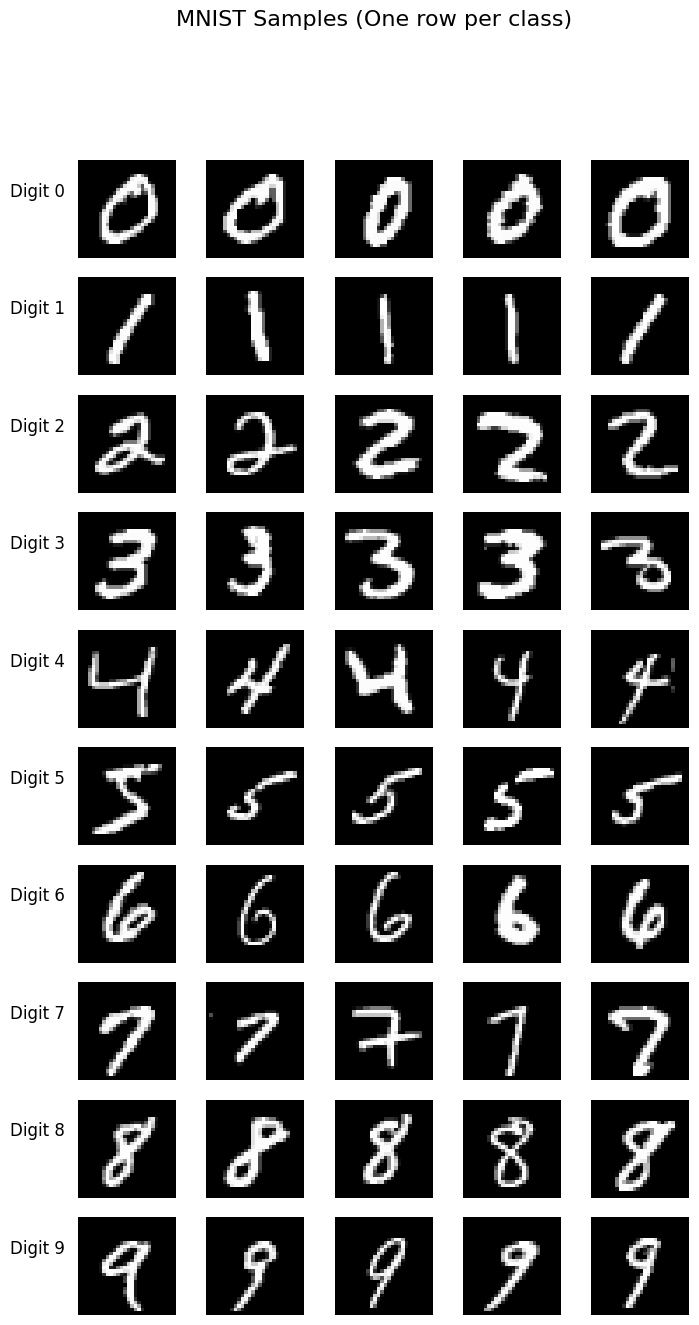

In [23]:
fig, axes = plt.subplots(10, 5, figsize=(8, 15))

# y comes as strings from openml ('0', '1', ...), so we compare with string
classes = sorted(np.unique(y))

for i, cls in enumerate(classes):
    # Get indices of all images belonging to this class
    # We assume y is an array of strings like '0', '1'
    idxs = np.where(y == cls)[0]
    
    # Take the first 5 examples
    for j in range(5):
        ax = axes[i, j]
        if j < len(idxs):
            # Reshape flat 784 vector to 28x28 image
            img = X[idxs[j]].reshape(28, 28)
            ax.imshow(img, cmap='gray')
        
        # Clean up axes
        ax.axis('off')
        
        # Add label to the left-most image of each row
        if j == 0:
            ax.text(-20, 10, f"Digit {cls}", fontsize=12)

plt.suptitle("MNIST Samples (One row per class)", fontsize=16)
plt.show()

In [24]:
X_scaled = X / 255.0 # this improves numerical stability and ensures that the "brightness" of a pixel is treated consistently across the image
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=5)

pca = PCA(n_components=80)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

To systematically find the best combination of hyperparameters for K-Means, you move from a simple loop (like your "Elbow Method" code) to a **Grid Search**.

Evaluating K-Means clustering on the MNIST dataset is unique because you have the ground truth labels (the actual digits 0-9). This allows you to use much more powerful evaluation metrics than standard unsupervised methods (like the Elbow method).

As such, I use Adjusted Rand Index scoring here

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import ParameterGrid
import pandas as pd
import numpy as np

# 1. Define the grid of hyperparameters you want to explore
param_grid = {
    # MNIST has 10 digits, but handwriting styles vary. 
    # Optimal K is often higher than 10 to capture different styles of '7', '1', etc.
    'n_clusters': [10, 15, 20, 25, 30], 
    
    # 'k-means++' usually converges faster, 'random' is the baseline
    # 'init': ['k-means++', 'random'], 
    'init': ['k-means++'],
    
    # # Number of times k-means will run with different seeds. Higher = better chance of global optimum.
    # 'n_init': [10, 20], 
    'n_init': [20],
    
    # # Max iterations for a single run
    # 'max_iter': [300, 500],
    'max_iter': [300],
    
    # # Tolerance to declare convergence (smaller = more precise but slower)
    # 'tol': [1e-4, 1e-3]
    'tol': [1e-40]
}

results = []

# 2. Iterate through every combination
# We use a subset for scoring speed, but fit on the whole train set
sample_size = 5000 
X_test_sample = X_test_reduced[:sample_size] # Use test set or subset of train for validation
y_test_sample = y_test[:sample_size]

print(f"Starting Grid Search with {len(ParameterGrid(param_grid))} combinations...")

for params in ParameterGrid(param_grid):
    
    # Initialize and Fit
    kmeans = KMeans(**params)
    kmeans.fit(X_train_reduced)
    
    # 3. Evaluate
    # Inertia: Sum of squared distances of samples to their closest cluster center.
    inertia = kmeans.inertia_
    
    # Note: Expensive calculation, so we use a sample.
    ari_score = adjusted_rand_score(y_test_sample, kmeans.predict(X_test_sample))
    
    # Store results
    result_entry = params.copy()
    result_entry['inertia'] = inertia
    result_entry['ari_score'] = ari_score
    results.append(result_entry)
    
    print(f"Finished params: {params} | Adjusted Rand Score: {ari_score:.4f}")

# 4. Convert to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by Silhouette Score (descending)
best_results = results_df.sort_values(by='ari_score', ascending=False)

print("\n--- Top 5 Configurations ---")
print(best_results.head(5))

Starting Grid Search with 5 combinations...
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.3602
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 15, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.3689
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 20, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.3426
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 25, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.3145
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 30, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.2968

--- Top 5 Configurations ---
        init  max_iter  n_clusters  n_init           tol       inertia  \
1  k-means++       300          15      20  1.000000e-40  1.737439e+06   
0  k-means++       300          10      20  1.000000e-40  1.873415e+06   
2  k-means++       300          20      20  

### 2\. Visualize the "Best" Cluster Centers

Once you have found the best `n_clusters` and parameters from the code above, the best way to interpret MNIST clustering is to visualize what the centroids actually look like.

Since you used PCA, we must utilize `pca.inverse_transform` to turn the 200-dimension centroids back into 784-dimension (28x28) images.

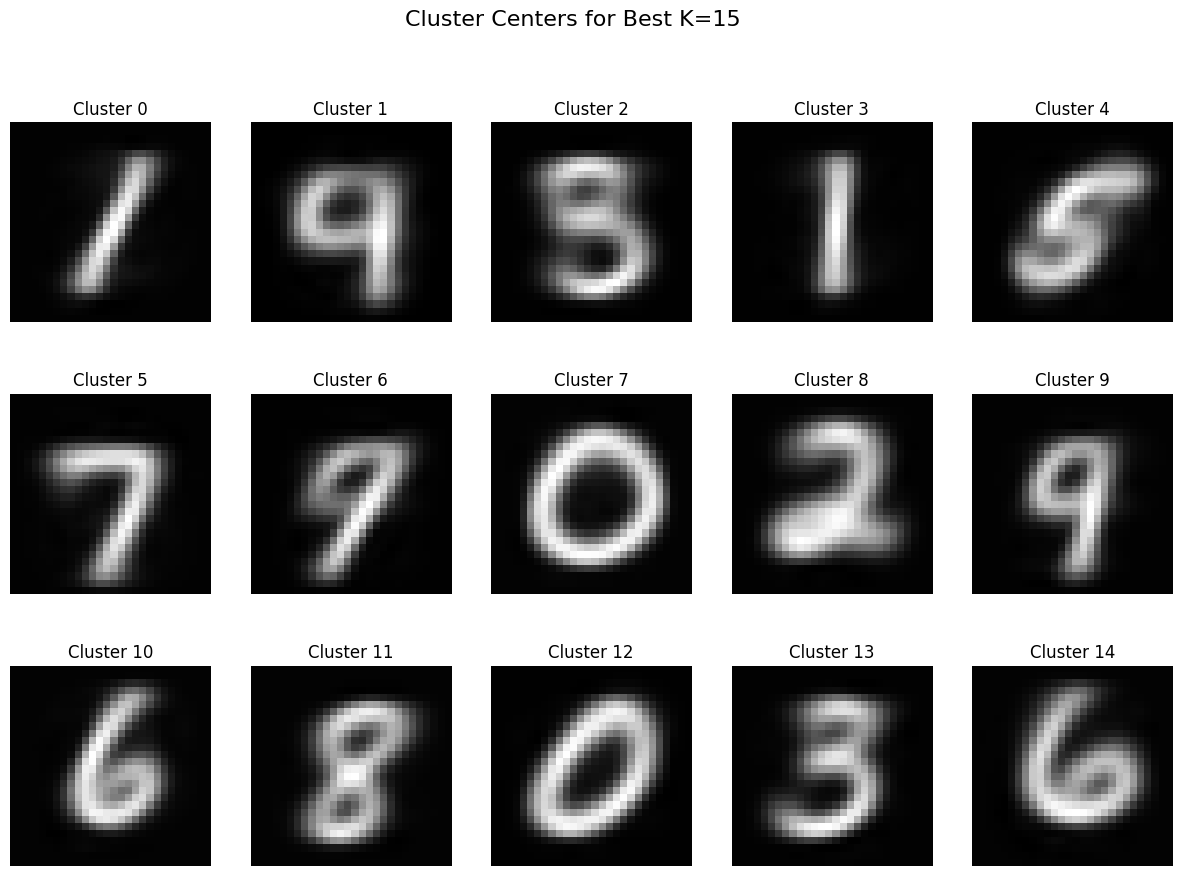

In [29]:
# 1. Retrain with the best parameters found above
best_params = best_results.iloc[0].to_dict()
# Remove scores from the dict to pass it into the model
del best_params['inertia']
del best_params['ari_score']

best_kmeans = KMeans(**best_params)
best_kmeans.fit(X_train_reduced)

# 2. Visualize the Centroids
# We need to inverse transform the centroids to get back to image space
centroids = best_kmeans.cluster_centers_
images_centroids = pca.inverse_transform(centroids)

# Plot
plt.figure(figsize=(15, 10))
K_best = best_params['n_clusters']

for i in range(K_best):
    ax = plt.subplot(int(np.ceil(K_best / 5)), 5, i + 1)
    # Reshape the 784 pixels back to 28x28
    plt.imshow(images_centroids[i].reshape(28, 28), cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')

plt.suptitle(f"Cluster Centers for Best K={K_best}", fontsize=16)
plt.show()

### 3\. Key Hyperparameters Explained

  * **`n_clusters`**: Don't restrict yourself to exactly 10. In unsupervised learning on MNIST, it is common to find 12–25 clusters. For example, a "2" written with a loop and a "2" written as a Z-shape might form two distinct, valid clusters.
  * **`init`**:
      * `'k-means++'`: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. Usually the best choice.
      * `'random'`: Chooses K observations (rows) at random from data for the initial centroids.
  * **`n_init`**: K-Means is sensitive to where it starts. If it starts in a "bad" spot, it might get stuck in a local minimum. `n_init` defines how many times the algorithm runs with different random starting points. It then picks the one with the lowest inertia. Increasing this improves stability but increases runtime.
  * **`tol`**: The tolerance regarding changes in the within-cluster sum-of-squares to declare convergence. If the model isn't changing much between iterations, it stops. Lowering this forces the model to be more precise.